In [42]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
%autoreload 2

import pandas as pd 
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from config import COLUMN_MAP, TREATMENT_COLS, COVARIATES, OUTCOME_VARS
import io
import math


In [44]:
def load_data(dir = '2021-SxS-Data-and-Data-Info',
              file = 'NFCS_2021_State_Data.csv'):
    """ 
    Load in the financial literacy dataset.

    Map columns to more verbose useful column names.
    """
    DATASET = os.path.join(dir, file)
    df = pd.read_csv(DATASET)
    col_list = list(df.columns)
    col_list = [COLUMN_MAP[col].strip() if col in COLUMN_MAP else col.strip() for col in col_list]
    df.columns = col_list
    
    return df

In [84]:
def subset_data(df: pd.DataFrame, write_cols: bool = False):
    """ 
    Subset the data and perform some operations.
    """
    

    if write_cols: 
        with open('columns.txt', 'wb') as file:
            file.write('\n'.join(df.columns).encode('utf-8'))
    
    def binarize_treat(t):
        if int(t) == 2:
            return 0 
        elif int(t) == 1:
            return 1
        else:
            print(f'Bad Treatment Value Encountered: {t}')

    # Use .loc to avoid SettingWithCopyWarning
    df = df.loc[df['FIN_ED_HS'].isin(['1','2']), :]
    df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat)

    all_cols = []
    all_cols.extend(OUTCOME_VARS)
    all_cols.extend(COVARIATES)
    all_cols.extend(TREATMENT_COLS)
    all_cols.extend('Z')
    df = df.loc[:, all_cols]
    
    return df

In [85]:
df = load_data()
df = subset_data(df)
df['Z'].value_counts()

/var/folders/1h/lbnzt8g120v24tjmpg9439ww0000gn/T/ipykernel_47442/15687144.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat)


Z
1    3345
0    2229
Name: count, dtype: int64

In [114]:
def get_finhealth_score(df):
    """ 
    Given OUTCOME_VARS in df, compute single score for financial health (higher = better).
    

    Remap col values as appropriate.

    Scale col weights for roughly balanced effect of each col relative to its severity.
    """

    for i in range(len(df)):

        overall_financial_score = 0

        local_outcome_vars = []
        for varname in OUTCOME_VARS:
            local_outcome_vars.append(int(df.iloc[i][varname]))
        
        finan_condition_satis = local_outcome_vars['SATISFACTION_WITH_FINANCIAL_CONDITION']
        overall_financial_score += float(local_outcome_vars['SATISFACTION_WITH_FINANCIAL_CONDITION'] - 1)

        spend_compar_inc = local_outcome_vars['SPENDING_COMPARISON_TO_INCOME']
        if spend_compar_inc == 1:
            overall_financial_score += 9
        elif spend_compar_inc == 2:
            overall_financial_score += 4.5
        elif spend_compar_inc == 3:
            overall_financial_score += 0

        diff_cover_expens = local_outcome_vars['DIFFICULTY_COVERING_EXPENSES']
        if diff_cover_expens == 1:
            overall_financial_score += 0
        elif diff_cover_expens == 2:
            overall_financial_score += 4.5
        elif diff_cover_expens == 3:
            overall_financial_score += 9

        emerg_funds = local_outcome_vars['EMERGENCY_FUNDS']
        if emerg_funds == 1:
            overall_financial_score += 9
        elif emerg_funds == 2:
            overall_financial_score += 0

        confid_come_up_with_2000 = local_outcome_vars['CONFIDENCE_COMING_UP_WITH_2000']
        if confid_come_up_with_2000 == 1:
            overall_financial_score += 9
        elif confid_come_up_with_2000 == 2:
            overall_financial_score += 3
        elif confid_come_up_with_2000 == 3:
            overall_financial_score += 6
        elif confid_come_up_with_2000 == 4:
            overall_financial_score += 0
        
        credit_rec_rat = local_outcome_vars['CREDIT_RECORD_RATING']
        if credit_rec_rat == 1:
            overall_financial_score += 9
        elif credit_rec_rat == 2:
            overall_financial_score += 0
        
        check_acct = local_outcome_vars['CHECKING_ACCOUNT']
        if check_acct == 1:
            overall_financial_score += 9
        elif check_acct == 2:
            overall_financial_score += 0
        
        save_acct = local_outcome_vars['SAVINGS_ACCOUNT']
        if save_acct == 1:
            overall_financial_score += 9
        elif save_acct == 2:
            overall_financial_score += 0

        overdraw = local_outcome_vars['OVERDRAW_CHECKING_ACCOUNT']
        if overdraw == 1:
            overall_financial_score += 0
        elif overdraw == 2:
            overall_financial_score += 9
        
        reg_retir_contrib = local_outcome_vars['REGULAR_CONTRIBUTION_TO_RETIREMENT']
        if reg_retir_contrib == 1:
            overall_financial_score += 9
        elif reg_retir_contrib == 2:
            overall_financial_score += 0
        
        other_invests = local_outcome_vars['OTHER_INVESTMENTS']
        if other_invests == 1:
            overall_financial_score += 9
        elif other_invests == 2:
            overall_financial_score += 0
        
        always_pay_credit_card = local_outcome_vars['ALWAYS_PAY_CR_FULL_12MO']
        if always_pay_credit_card == 1:
            overall_financial_score += 9
        elif always_pay_credit_card == 2:
            overall_financial_score += 0

        payday_loan = local_outcome_vars['USED_PAYDAY_LOAN']
        if payday_loan == 1:
            overall_financial_score += 9
        elif payday_loan == 2:
            overall_financial_score += 3
        elif payday_loan == 3:
            overall_financial_score += 2
        elif payday_loan == 4:
            overall_financial_score += 1
        
        debt_collected = local_outcome_vars['DEBT_COLLECTED_12MO']
        if debt_collected == 1:
            overall_financial_score += 0
        elif debt_collected == 2:
            overall_financial_score += 9
        
        too_much_debt = local_outcome_vars['TOO_MUCH_DEBT_STRENGTH']
        if too_much_debt == 1:
            overall_financial_score += 9
        elif too_much_debt == 2:
            overall_financial_score += 7.5
        elif too_much_debt == 3:
            overall_financial_score += 6
        elif too_much_debt == 4:
            overall_financial_score += 4.5
        elif too_much_debt == 5:
            overall_financial_score += 3
        elif too_much_debt == 6:
            overall_financial_score += 1.5
        elif too_much_debt == 7:
            overall_financial_score += 0

        d2d_finan_skill = local_outcome_vars['D2D_FINANCIAL_SKILL']
        overall_financial_score += (float(d2d_finan_skill) - 1) * 1.5

        finan_knowledge = local_outcome_vars['FINANCIAL_KNOWLEDGE_ASSESS']
        overall_financial_score += (float(finan_knowledge) - 1) * 1.5

        return overall_financial_score


In [115]:
def visualize_data(df: pd.DataFrame):
    """ 
    Visualize the covariates and the treatment variable distributions.
    """
    num_covariates = len(COVARIATES)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = math.ceil(num_covariates / num_cols)

    # Create the first figure for covariates
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(35, 35))
    fig.subplots_adjust(hspace=0.5)

    # Visualize covariates with pie charts
    for i, covariate in enumerate(COVARIATES):
        row, col = divmod(i, num_cols)
        ax = axes[row, col]
        df[covariate].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=ax)
        ax.set_title(f'{covariate} Distribution')

    # Remove empty subplots if there are extras
    for i in range(num_covariates, num_rows*num_cols):
        row, col = divmod(i, num_cols)
        fig.delaxes(axes[row, col])

    plt.show()

    # Create the second figure for the treatment variable
    plt.figure(figsize=(8, 8))

    # Visualize the treatment variable with a pie chart
    ax2 = plt.gca()
    df['Z'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=ax2)
    ax2.set_title('Treatment Distribution')

    plt.show()




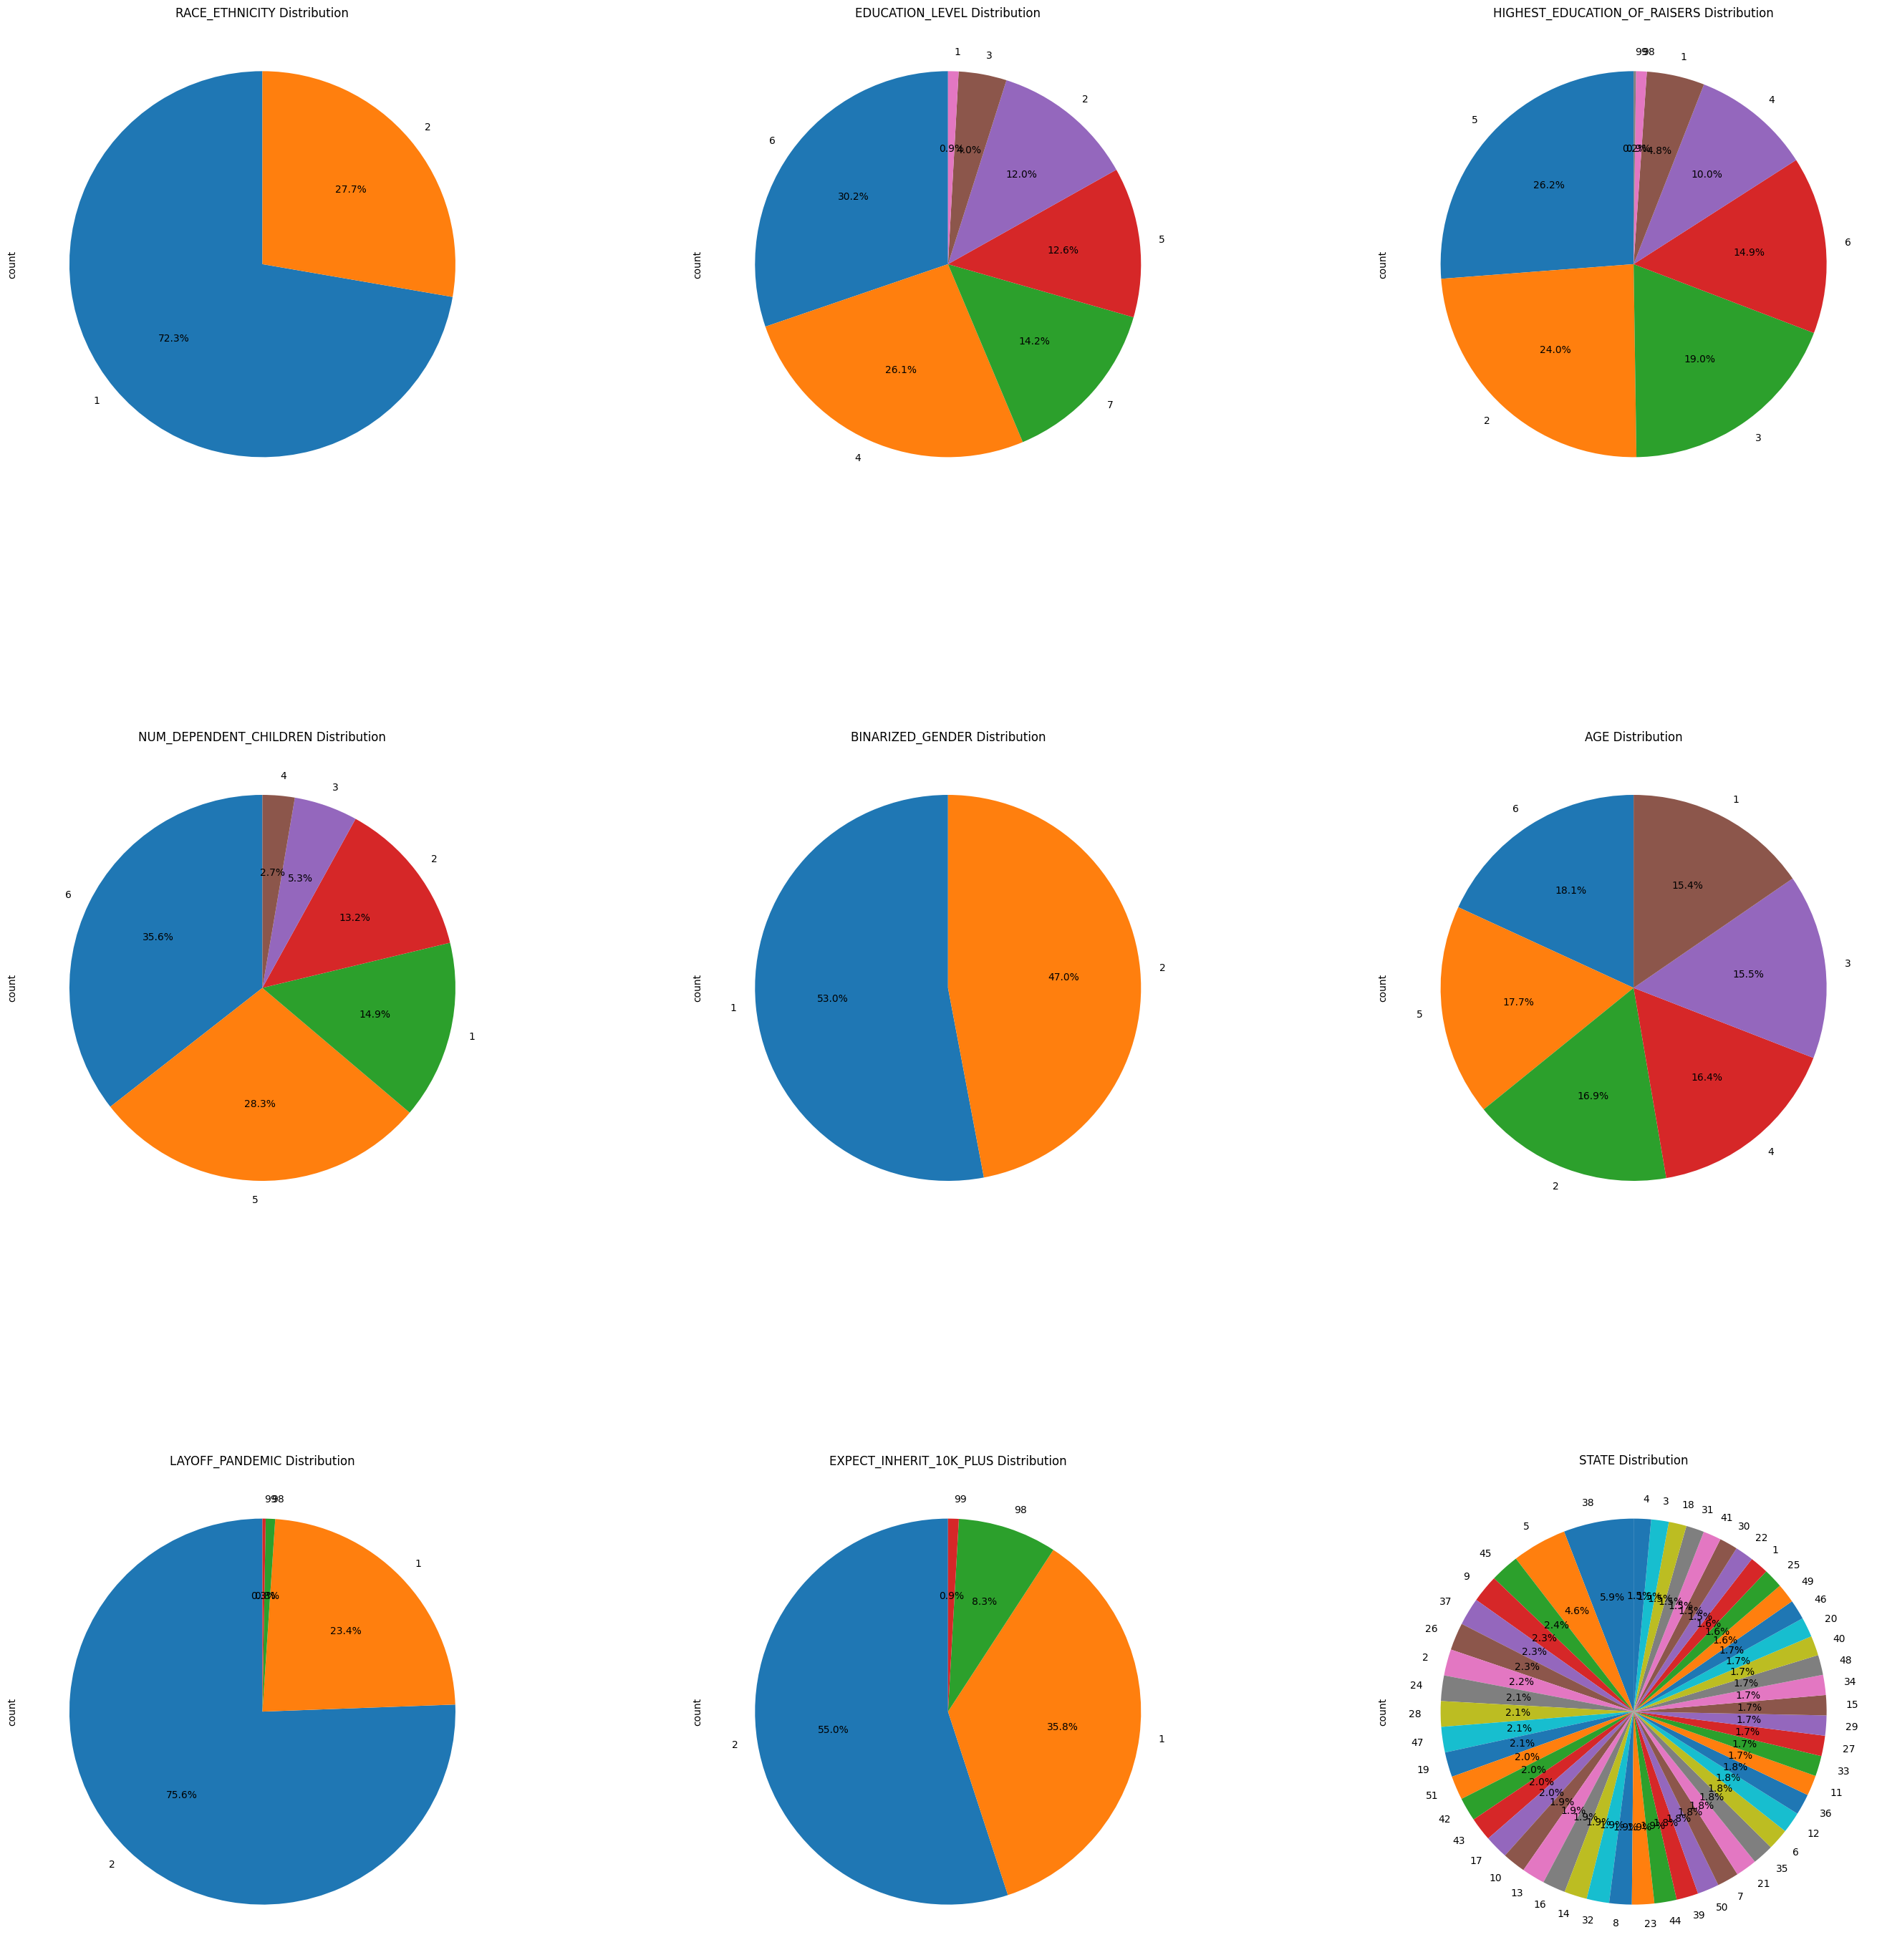

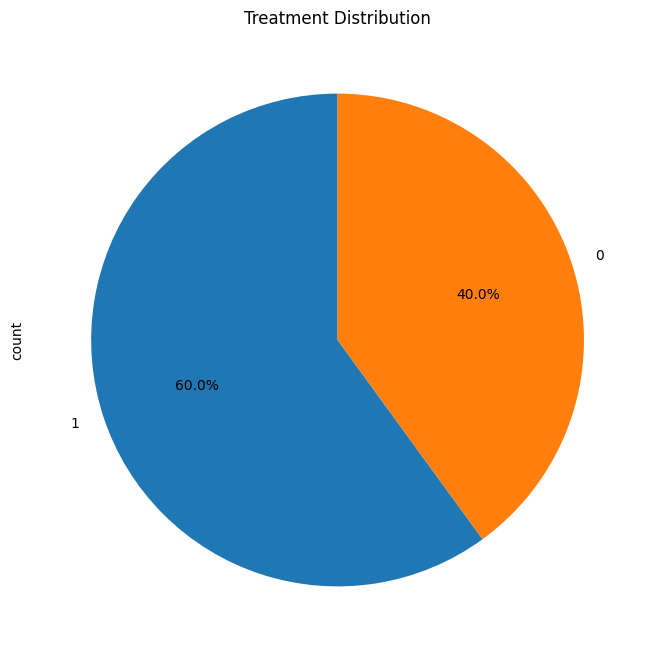

In [116]:
visualize_data(df)